# Imports

In [1]:
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision.datasets import CIFAR10, CIFAR100
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
import torchvision.utils as vision_utils
from scipy.stats import truncnorm
import torchvision
from matplotlib.ticker import NullFormatter
import copy
from typing import Any, Callable, List, Optional, Type, Union


DEVICE = torch.device('cuda')

In [2]:
!nvidia-smi

Sat Feb  5 11:37:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    33W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Fetch CIFAR10

In [3]:
def plot_samples(dataset, nrow=13, figsize=(10,7)):
  try:
    X, Y = dataset.tensors
  except:
    try:
      (X,) = dataset.tensors
    except:
      X = dataset
  fig = plt.figure(figsize=figsize, dpi=130)
  grid_img = vision_utils.make_grid(X[:nrow].cpu(), nrow=nrow, normalize=True, padding=1)
  _ = plt.imshow(grid_img.permute(1, 2, 0), interpolation='nearest')
  _ = plt.tick_params(axis=u'both', which=u'both',length=0)
  ax = plt.gca()
  _ = ax.xaxis.set_major_formatter(NullFormatter()) 
  _ = ax.yaxis.set_major_formatter(NullFormatter()) 
  plt.show()

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


Train size: 22544
Valid size: 2456
Test size: 5000


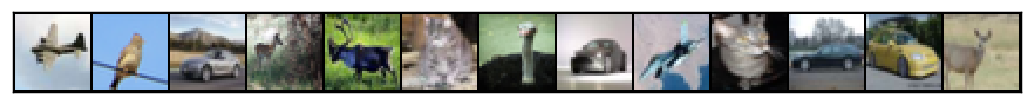

In [4]:
def get_pytorch_dataset(dataset, device, classes_to_keep=None):
  X, Y = [], []
  for x, y in dataset:
    if classes_to_keep is not None and y in classes_to_keep:
      X.append(torch.tensor(x))
      Y.append(y)
    elif classes_to_keep is None:
      X.append(torch.tensor(x))
      Y.append(y)
  X = torch.stack(X).to(device)
  Y = torch.tensor(Y).long().to(device)
  return TensorDataset(X, Y)

train_data = CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_data, valid_data = random_split(train_data, [45000, 5000])

train_data = get_pytorch_dataset(train_data, DEVICE, classes_to_keep=[0,1,2,3,4])
valid_data = get_pytorch_dataset(valid_data, DEVICE, classes_to_keep=[0,1,2,3,4])
test_data = get_pytorch_dataset(test_data, DEVICE, classes_to_keep=[0,1,2,3,4])

train_dl = DataLoader(train_data, batch_size=256, shuffle=True)
valid_dl = DataLoader(valid_data, batch_size=1024, shuffle=False)
test_dl  = DataLoader(test_data, batch_size=1024, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(f"Train size: {len(train_dl.dataset)}")
print(f"Valid size: {len(valid_dl.dataset)}")
print(f"Test size: {len(test_dl.dataset)}")

plot_samples(train_data)

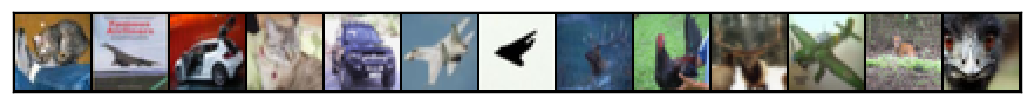

In [5]:
plot_samples(test_data)

# Get $\mathcal{D}_\text{ood}$

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


OOD size: 30000


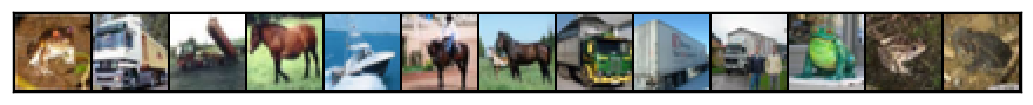

In [6]:
train_data = CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_data = get_pytorch_dataset(train_data, DEVICE, classes_to_keep=[5,6,7,8,9])
test_data = get_pytorch_dataset(test_data, DEVICE, classes_to_keep=[5,6,7,8,9])

X_train, Y_train = train_data.tensors
X_test, Y_test = test_data.tensors

perturb_data = TensorDataset(torch.cat((X_train, X_test)), torch.cat((Y_train, Y_test)))

perturb_dl = DataLoader(perturb_data, batch_size=256, shuffle=True)

print(f"OOD size: {len(perturb_dl.dataset)}")

plot_samples(perturb_data)

# Fetch CIFAR100

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Test size: 10000


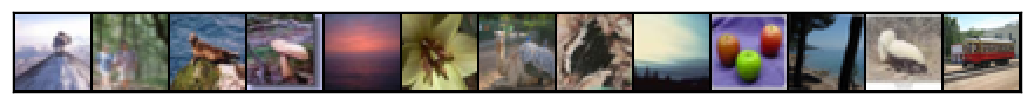

In [7]:
test_data_c100 = CIFAR100(root='./data', train=False, download=True, transform=transforms.ToTensor())

test_data_c100 = get_pytorch_dataset(test_data_c100, DEVICE)

test_dl_c100  = DataLoader(test_data_c100, batch_size=1024, shuffle=False)

print(f"Test size: {len(test_dl_c100.dataset)}")

plot_samples(test_data_c100)

# Model

This is a ResNet-18 with added dropout for MC-dropout. The fist convolution (conv1) is modified for better results on CIFAR-10: 
* `kernel_size`: 7 --> 3 
* `stride`: 2 --> 1 
* `padding`: 3 -->1

The method `model.set_sample(True)` can be used to keep using dropout even with the model in eval mode (to prevent updating batch-norm parameters).

In [8]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        dropout_p: float = 0.5,
        sample: bool = True
    ) -> None:
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        
        self.dropout_p = dropout_p
        self.sample = sample
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        # if training or sampling, mc dropout will apply random binary mask
        # Otherwise, for regular test set evaluation, we can just scale activations
        mask = self.training or self.sample

        identity = x

        x = self.MC_dropout(x, p=self.dropout_p, mask=mask)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.MC_dropout(out, p=self.dropout_p, mask=mask)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

    def MC_dropout(self, act_vec, p=0.5, mask=True):
        return F.dropout(act_vec, p=p, training=mask)


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        dropout_p: float = 0.5,
        sample: bool = True
    ) -> None:
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        self.dropout_p = dropout_p
        self.sample = sample

        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:

        mask = self.training or self.sample

        identity = x

        x = self.MC_dropout(x, p=self.dropout_p, mask=mask)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.MC_dropout(out, p=self.dropout_p, mask=mask)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.MC_dropout(out, p=self.dropout_p, mask=mask)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

    def MC_dropout(self, act_vec, p=0.5, mask=True):
        return F.dropout(act_vec, p=p, training=mask)


class ResNet(nn.Module):

    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        dropout_p: float = 0.5,
        sample: bool = True,
    ) -> None:
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        self.dropout_p = dropout_p
        self.sample = sample

        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        # CIFAR: kernel_size 7 -> 3, stride 2 -> 1, padding 3->1
        self.conv1_planes = 64
        self.conv1 = nn.Conv2d(
            3, self.conv1_planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        # Remove maxpool layer from forward by changing it into an identity layer
        self.maxpool = nn.Identity()
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]


    def _make_layer(self, block: Type[Union[BasicBlock, Bottleneck]], planes: int, blocks: int,
                    stride: int = 1, dilate: bool = False) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer, dropout_p=self.dropout_p))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer, dropout_p=self.dropout_p))

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # if training or sampling, mc dropout will apply random binary mask
        # Otherwise, for regular test set evaluation, we can just scale activations
        mask = self.training or self.sample

        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

    def MC_dropout(self, act_vec, p=0.5, mask=True):
        return F.dropout(act_vec, p=p, training=mask)

    def set_sample(self, sample):
        self.sample = sample
        layers = [self.layer1, self.layer2,
                  self.layer3, self.layer4]
        for layer in layers:
            for block in layer.children():
                block.sample = sample


def _resnet(
    arch: str,
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    pretrained: bool,
    progress: bool,
    **kwargs: Any
) -> ResNet:
    model = ResNet(block, layers, **kwargs)
    return model


def resnet18MCD(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)

# Utils

In [9]:
@torch.no_grad()
def get_acc(model, dl): # Eval without dropout
  model.eval()
  model.set_sample(False)
  acc = []
  for X, y in dl:
    acc.append(torch.argmax(model(X), dim=1) == y)
  acc = torch.cat(acc)
  acc = torch.sum(acc)/len(acc)
  model.train()
  model.set_sample(True)
  return acc.item()


@torch.no_grad()
def get_ensemble_acc(models, dl): # Eval without dropout, eval the ensemble 
  for model in models:
    model.eval()
    model.set_sample(False)
  acc = []
  for X, y in dl:
    outs = [torch.softmax(model(X), dim=1) for model in models]
    outs = torch.stack(outs, dim=0).mean(dim=0)
    acc.append(torch.argmax(outs, dim=1) == y)
  acc = torch.cat(acc)
  acc = torch.sum(acc)/len(acc)
  for model in models:
    model.train()
    model.set_sample(True)
  return acc.item()


@torch.no_grad()
def get_probas_mcd(model, dl, num_samples=10, use_dropout=True): 
  # return the proabilities for samples using MC-dropout (unless use_dropout=False)
  model.eval()
  model.set_sample(use_dropout)
  probs = []
  for X, y in dl:
    outs = [model(X) for x in range(num_samples)]
    ps = [torch.softmax(out, dim=1) for out in outs]
    mean_ps = torch.stack(ps).mean(dim=0)
    probs.append(mean_ps)
  probs = torch.cat(probs)
  return probs


@torch.no_grad()
def get_probas_ensemble(models, dl): 
  for model in models:
    model.eval()
    model.set_sample(False)
  probs = []
  for X, y in dl:
    outs = [model(X) for model in models]
    ps = [torch.softmax(out, dim=1) for out in outs]
    mean_ps = torch.stack(ps).mean(dim=0)
    probs.append(mean_ps)
  probs = torch.cat(probs)
  return probs


def plot_hist(probas):
  fig, (ax) = plt.subplots(1,1,figsize=(3,3), dpi=110)

  ax.grid()

  ax.set_xlabel("largest probability")
  ax.set_ylabel("Number of datapoints")

  _ = ax.hist(probas, bins=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], linestyle='solid', color='g')
  ax.set_xlim(0, 1)

# Training utils

In [10]:
def dl_to_sampler(dl):
  dl_iter = iter(dl)
  def sample():
    nonlocal dl_iter
    try:
      return next(dl_iter)
    except StopIteration:
      dl_iter = iter(dl)
      return next(dl_iter)
  return sample


def sequential_train(num_models, train_dl, valid_dl, perturb_dl, alpha=1, max_epoch=30,
                     use_diversity_reg=True, lr=0.2, weight_decay=1e-5, dropout=0.2):
  
  models = [resnet18MCD(num_classes=5, dropout_p=dropout).to(DEVICE) for _ in range(num_models)]
  
  stats = {f"m{i+1}": {"acc": [], "loss": [], "adv-loss": []} for i in range(len(models))}

  for m_idx, m in enumerate(models):

    for m_ in models[:m_idx]:
      m_.eval()
      m.set_sample(False)

    opt = torch.optim.SGD(m.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay, nesterov=True)
    scheduler = torch.optim.lr_scheduler.CyclicLR(opt, 0, lr, step_size_up=(len(train_dl)*max_epoch)//2, mode='triangular', cycle_momentum=False)

    perturb_sampler = dl_to_sampler(perturb_dl)

    for epoch in range(max_epoch):
      for itr, (x, y) in enumerate(train_dl):
        (x_tilde,  _) = perturb_sampler()
        erm_loss = F.cross_entropy(m(x), y)
        
        if use_diversity_reg and m_idx != 0:
          adv_loss = []

          p_2 = torch.softmax(m(x_tilde), dim=1)
          p_2_1, max_idx = p_2.max(dim=1)
          p_2_0 = 1. - p_2_1

          with torch.no_grad():
            p_1_s = [torch.softmax(m_(x_tilde), dim=1) for m_ in models[:m_idx]]
            p_1_1_s = [p_1[torch.arange(len(p_1)), max_idx] for p_1 in p_1_s]
            p_1_0_s = [1. - p_1_1 for p_1_1 in p_1_1_s]
          
          for i in range(len(p_1_s)):
            al = (- torch.log(p_1_1_s[i] * p_2_0 + p_2_1 * p_1_0_s[i] +  1e-7)).mean()
            adv_loss.append(al)
        else:
          adv_loss = [torch.tensor([0]).to(DEVICE)]

        adv_loss = sum(adv_loss)/len(adv_loss)
        loss = erm_loss + alpha * adv_loss

        opt.zero_grad()
        loss.backward()
        opt.step()
        scheduler.step()

        if (itr + epoch * len(train_dl)) % 200 == 0:
          itr_ = itr + epoch * len(train_dl)
          print_str = f"[m{m_idx+1}] {epoch}/{itr_} [train] loss: {erm_loss.item():.2f} adv-loss: {adv_loss.item():.2f} "
          stats[f"m{m_idx+1}"]["loss"].append((itr_, erm_loss.item()))
          stats[f"m{m_idx+1}"]["adv-loss"].append((itr_, adv_loss.item()))
          acc = get_acc(m, valid_dl)
          stats[f"m{m_idx+1}"]["acc"].append((itr_, acc))
          print_str += f" acc: {acc:.2f} "
          if itr_ != 0 and scheduler is not None:
            print_str += f"[lr] {scheduler.get_last_lr()[0]:.5f} "
          print(print_str)
        
        itr += 1

  stats['all_models'] = models

  return stats

# Train with D-BAT

In [17]:
stats = sequential_train(4, train_dl, valid_dl, perturb_dl, alpha=0.2, 
                         max_epoch=60, use_diversity_reg=True, lr=0.2, 
                         weight_decay=5e-4, dropout=0.2)

[m1] 0/0 [train] loss: 1.67 adv-loss: 0.00  acc: 0.23 
[m1] 2/200 [train] loss: 1.06 adv-loss: 0.00  acc: 0.27 [lr] 0.01523 
[m1] 4/400 [train] loss: 0.79 adv-loss: 0.00  acc: 0.42 [lr] 0.03038 
[m1] 6/600 [train] loss: 0.71 adv-loss: 0.00  acc: 0.57 [lr] 0.04553 
[m1] 9/800 [train] loss: 0.55 adv-loss: 0.00  acc: 0.62 [lr] 0.06068 
[m1] 11/1000 [train] loss: 0.53 adv-loss: 0.00  acc: 0.74 [lr] 0.07583 
[m1] 13/1200 [train] loss: 0.37 adv-loss: 0.00  acc: 0.78 [lr] 0.09098 
[m1] 15/1400 [train] loss: 0.37 adv-loss: 0.00  acc: 0.82 [lr] 0.10614 
[m1] 18/1600 [train] loss: 0.22 adv-loss: 0.00  acc: 0.84 [lr] 0.12129 
[m1] 20/1800 [train] loss: 0.18 adv-loss: 0.00  acc: 0.84 [lr] 0.13644 
[m1] 22/2000 [train] loss: 0.22 adv-loss: 0.00  acc: 0.83 [lr] 0.15159 
[m1] 25/2200 [train] loss: 0.15 adv-loss: 0.00  acc: 0.82 [lr] 0.16674 
[m1] 27/2400 [train] loss: 0.14 adv-loss: 0.00  acc: 0.87 [lr] 0.18189 
[m1] 29/2600 [train] loss: 0.12 adv-loss: 0.00  acc: 0.88 [lr] 0.19705 
[m1] 31/2800 [tra

In [18]:
get_ensemble_acc(stats['all_models'], test_dl)

0.9197999835014343

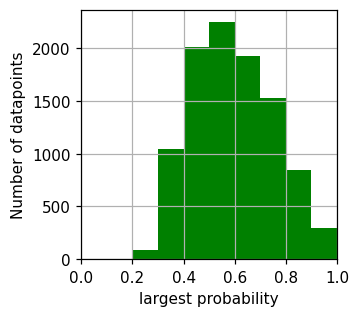

In [19]:
probas_ensemble_c100 = get_probas_ensemble(stats['all_models'], test_dl_c100)
probas_ensemble_c100 = probas_ensemble_c100.max(dim=1).values.cpu().numpy()
plot_hist(probas_ensemble_c100)

# Train without D-BAT

In [20]:
stats = sequential_train(4, train_dl, valid_dl, perturb_dl, alpha=0.0, 
                         max_epoch=60, use_diversity_reg=False, lr=0.2, 
                         weight_decay=1e-5, dropout=0.2)

[m1] 0/0 [train] loss: 1.86 adv-loss: 0.00  acc: 0.21 
[m1] 2/200 [train] loss: 1.02 adv-loss: 0.00  acc: 0.23 [lr] 0.01523 
[m1] 4/400 [train] loss: 0.86 adv-loss: 0.00  acc: 0.42 [lr] 0.03038 
[m1] 6/600 [train] loss: 0.71 adv-loss: 0.00  acc: 0.59 [lr] 0.04553 
[m1] 9/800 [train] loss: 0.60 adv-loss: 0.00  acc: 0.74 [lr] 0.06068 
[m1] 11/1000 [train] loss: 0.51 adv-loss: 0.00  acc: 0.69 [lr] 0.07583 
[m1] 13/1200 [train] loss: 0.33 adv-loss: 0.00  acc: 0.72 [lr] 0.09098 
[m1] 15/1400 [train] loss: 0.39 adv-loss: 0.00  acc: 0.76 [lr] 0.10614 
[m1] 18/1600 [train] loss: 0.24 adv-loss: 0.00  acc: 0.87 [lr] 0.12129 
[m1] 20/1800 [train] loss: 0.17 adv-loss: 0.00  acc: 0.86 [lr] 0.13644 
[m1] 22/2000 [train] loss: 0.16 adv-loss: 0.00  acc: 0.86 [lr] 0.15159 
[m1] 25/2200 [train] loss: 0.11 adv-loss: 0.00  acc: 0.87 [lr] 0.16674 
[m1] 27/2400 [train] loss: 0.12 adv-loss: 0.00  acc: 0.88 [lr] 0.18189 
[m1] 29/2600 [train] loss: 0.07 adv-loss: 0.00  acc: 0.89 [lr] 0.19705 
[m1] 31/2800 [tra

## Test without MC-Dropout (deep ensemble)

In [21]:
get_ensemble_acc(stats['all_models'], test_dl)

0.9143999814987183

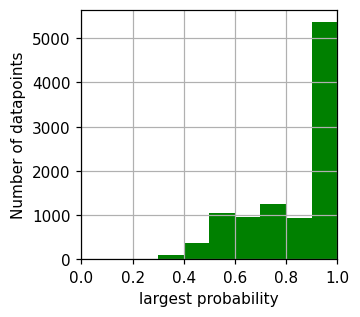

In [22]:
probas_ensemble_c100 = get_probas_ensemble(stats['all_models'], test_dl_c100)
probas_ensemble_c100 = probas_ensemble_c100.max(dim=1).values.cpu().numpy()
plot_hist(probas_ensemble_c100)

## Test with MC-Dropout

Accuracy: 0.902999997138977
Accuracy: 0.9081999659538269
Accuracy: 0.9053999781608582
Accuracy: 0.9016000032424927


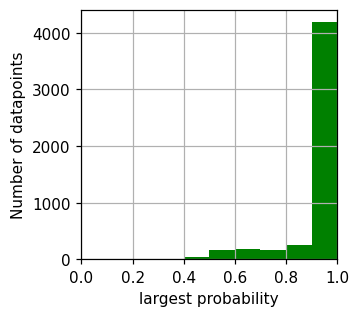

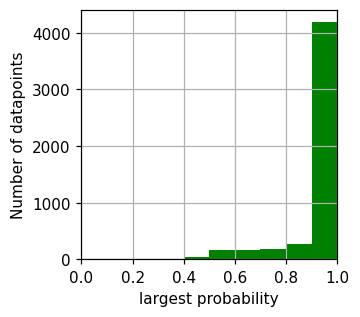

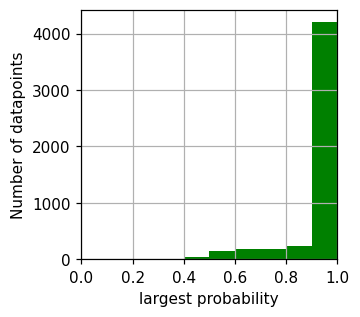

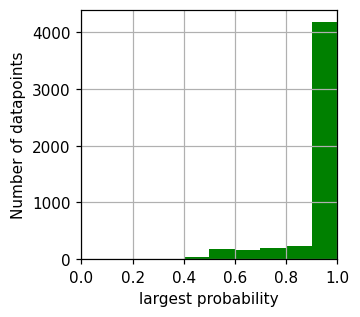

In [23]:
Y = torch.cat([x[1] for x in test_dl])

for i in range(4):
  probas = get_probas_mcd(stats['all_models'][i], test_dl, num_samples=20, use_dropout=True)
  probas_mcd_c100 = probas.max(dim=1).values.cpu().numpy()
  plot_hist(probas_mcd_c100)

  acc = torch.argmax(probas, dim=1) == Y
  print("Accuracy:", acc.float().mean().item())